In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from scipy import linalg
import scipy.integrate as integrate
from scipy.special import gamma
import time

from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture._gaussian_mixture import _estimate_log_gaussian_prob, _compute_precision_cholesky, _estimate_gaussian_covariances_full
from sklearn.utils import check_random_state
from sklearn import cluster
from sklearn.model_selection import KFold

from sklearn.feature_selection import mutual_info_regression

In [3]:
class my_GMM(GMM):
    """
    Custom GMM class based on the sklearn GMM class.
    This allows to work with a GMM with fixed parameters, without fitting it.
    It also allows to estimate MI with a certain number of MC samples.
    The different initialisation types are dealt with separately.
    """
    def __init__(self,
                 n_components=1,
                 covariance_type="full",
                 tol=1e-5,
                 reg_covar=1e-6,
                 max_iter=100,
                 n_init=1,
                 init_params="random",
                 random_state=None,
                 warm_start=False,
                 verbose=0,
                 verbose_interval=10,
                 weights_init=None,
                 means_init=None,
                 precisions_init=None,
                 covariances_init=None
                 ):
        super(my_GMM, self).__init__(n_components=n_components,
                 covariance_type=covariance_type,
                 tol=tol,
                 reg_covar=reg_covar,
                 max_iter=max_iter,
                 n_init=n_init,
                 init_params=init_params,
                 random_state=random_state,
                 warm_start=warm_start,
                 verbose=verbose,
                 verbose_interval=verbose_interval,
                 weights_init=weights_init,
                 means_init=means_init,
                 precisions_init=precisions_init,
                )

        self.means_ = means_init
        self.covariances_ = covariances_init
        self.covariances_init = covariances_init
        self.weights_ = weights_init
        #self.random_state = random_state
        #self.covariance_type = covariance_type
        #self.precisions_cholesky_ = _compute_precision_cholesky(
        #        self.covariances_, self.covariance_type
        #    )


    def score_samples(self, X):
        """Compute the log-likelihood of each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)

        return logsumexp(self._estimate_weighted_log_prob(X), axis=1)

    def predict(self, X):
        """Predict the labels for the data samples in X using trained model.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        return self._estimate_weighted_log_prob(X).argmax(axis=1)

    def predict_proba(self, X):
        """Evaluate the components' density for each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        resp : array, shape (n_samples, n_components)
            Density of each Gaussian component for each sample in X.
        """
        # copied here to remove the fitting check
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        _, log_resp = self._estimate_log_prob_resp(X)
        return np.exp(log_resp)

    def sample(self, n_samples=1):
        """Generate random samples from the fitted Gaussian distribution.
        Parameters
        ----------
        n_samples : int, default=1
            Number of samples to generate.
        Returns
        -------
        X : array, shape (n_samples, n_features)
            Randomly generated sample.
        y : array, shape (nsamples,)
            Component labels.
        """
        # copied here to remove the fitting check
        # check_is_fitted(self)

        if n_samples < 1:
            raise ValueError(
                "Invalid value for 'n_samples': %d . The sampling requires at "
                "least one sample." % (self.n_components)
            )

        _, n_features = self.means_.shape
        rng = check_random_state(self.random_state)
        n_samples_comp = rng.multinomial(n_samples, self.weights_)

        if self.covariance_type == "full":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, covariance, int(sample))
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )
        elif self.covariance_type == "tied":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, self.covariances_, int(sample))
                    for (mean, sample) in zip(self.means_, n_samples_comp)
                ]
            )
        else:
            X = np.vstack(
                [
                    mean + rng.randn(sample, n_features) * np.sqrt(covariance)
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )

        y = np.concatenate(
            [np.full(sample, j, dtype=int) for j, sample in enumerate(n_samples_comp)]
        )

        return (X, y)

    def score_samples_marginal(self, X, index=0):
        """Compute the log-likelihood of each sample for the marginal model, indexed by either 0 (x) or 1 (y).
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        index: integer
            Either 0 (marginal x) or 1 (marginal y).
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """

        oned_cholesky = np.sqrt(1/self.covariances_[:, index, index]).reshape(-1, 1, 1)
        marginal_logprob = _estimate_log_gaussian_prob(
            X, self.means_[:, index].reshape(-1, 1), oned_cholesky, self.covariance_type
        )

        return logsumexp(np.log(self.weights_) + marginal_logprob, axis=1)


    def estimate_MI_MC(self, MC_samples=100):
        """
        Compute the mutual information (MI) associated with a particular GMM model, using MC integration
        Parameters
        ----------
        MC_samples : integer
            Number of Monte Carlo samples to perform numerical integration of the MI integral.
        Returns
        ----------
        MI : integer
            The value of mutual information.
        -------
        """
        # sample MC samples
        points, clusters = self.sample(MC_samples)
        
        # we first evaluate the log-likelihood for the joint probability
        joint = self.score_samples(points)

        # we then evaluate the marginals; index=0 corresponds to x, index=y corresponds to y
        marginal_x = self.score_samples_marginal(points[:, :1], index=0)
        marginal_y = self.score_samples_marginal(points[:, 1:], index=1)

        MI = np.mean(joint - marginal_x - marginal_y)
        return MI
    
    def fit_predict(self, X, y=None):
        """Estimate model parameters using X and predict the labels for X.
        The method fits the model n_init times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times until the change of likelihood or lower bound is less than
        `tol`, otherwise, a :class:`~sklearn.exceptions.ConvergenceWarning` is
        raised. After fitting, it predicts the most probable label for the
        input data points.
        .. versionadded:: 0.20
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        y : Ignored
            Not used, present for API consistency by convention.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        X = self._validate_data(X, dtype=[np.float64, np.float32], ensure_min_samples=2)
        if X.shape[0] < self.n_components:
            raise ValueError(
                "Expected n_samples >= n_components "
                f"but got n_components = {self.n_components}, "
                f"n_samples = {X.shape[0]}"
            )
        self._check_initial_parameters(X)

        # if we enable warm_start, we will have a unique initialisation
        do_init = not (self.warm_start and hasattr(self, "converged_"))
        n_init = self.n_init if do_init else 1

        max_lower_bound = -np.inf
        self.converged_ = False

        random_state = check_random_state(self.random_state)

        n_samples, _ = X.shape
        for init in range(n_init):
            self._print_verbose_msg_init_beg(init)

            if do_init:
                self._initialize_parameters(X, random_state)

            lower_bound = -np.inf if do_init else self.lower_bound_

            for n_iter in range(1, self.max_iter + 1):
                #if n_iter==179:
                #    try:
                #        #print(n_iter)
                #        print(np.linalg.eig(self.covariances_[2]))
                #        #print(self.means_[2])
                #        #ind = np.argsort(log_resp[:, 2])[-5:]
                #        #print(X[ind])
                #        #print(log_resp[np.argmax(log_resp[:, 2])])
                #        #plt.hist(log_resp[:, 4])
                #    except:
                #        pass

                prev_lower_bound = lower_bound

                log_prob_norm, log_resp = self._e_step(X)
                self._m_step(X, log_resp)
                lower_bound = self._compute_lower_bound(log_resp, log_prob_norm)

                change = lower_bound - prev_lower_bound
                self._print_verbose_msg_iter_end(n_iter, change)

                if abs(change) < self.tol:
                    self.converged_ = True
                    break

            self._print_verbose_msg_init_end(lower_bound)

            if lower_bound > max_lower_bound or max_lower_bound == -np.inf:
                max_lower_bound = lower_bound
                best_params = self._get_parameters()
                best_n_iter = n_iter

        if not self.converged_:
            warnings.warn(
                "Initialization %d did not converge. "
                "Try different init parameters, "
                "or increase max_iter, tol "
                "or check for degenerate data." % (init + 1),
                ConvergenceWarning,
            )

        self._set_parameters(best_params)
        self.n_iter_ = best_n_iter
        self.lower_bound_ = max_lower_bound

        # Always do a final e-step to guarantee that the labels returned by
        # fit_predict(X) are always consistent with fit(X).predict(X)
        # for any value of max_iter and tol (and any random_state).
        _, log_resp = self._e_step(X)

        return log_resp.argmax(axis=1)
        


In [4]:
# now we also focus on initialising the GMM parameters
# we provide four different initialisation types, which return weights, means and covs
# these will go as input into the GMM class, so that we can ignore whatever happens there

  
def initialize_parameters(X, random_state, n_components=1, s=None, reg_covar=1e-6, init_type='random'):
    """Initialize the model parameters.
    Parameters
    ----------
    X : array-like of shape  (n_samples, n_features)
    random_state : RandomState
        A random number generator instance that controls the random seed used for the method chosen to initialize the parameters.
    n_components: int
        Number of components of the GMM to fit.
    s : float
        If set, sets component variances in the 'random' and 'minmax' cases. 
        If s is not given, it will be set such that the volume of all components
        completely fills the space covered by data.
    init_type : {'random', 'minmax', 'kmeans', 'random_sklearn', 'kmeans_sklearn'}, default='random'
        The method used to initialize the weights, the means and the
        precisions.
        Must be one of:
            'random': weights are set uniformly, covariances are proprtional to identity (with prefactor s^2). 
            For each mean, a data sample is selected at random, and a multivariant Gaussian with variance s^2 offset is added.
            'minmax': same as above, but means are distributed randomly over the range that is covered by data.
            'kmeans': k-means clustering run as in Algorithm 1 from Bloemer & Bujna (arXiv:1312.5946), as implemented by Melchior & Goulding (arXiv:1611.05806)
             WARNING: The result of this call are not deterministic even if rng is set because scipy.cluster.vq.kmeans2 uses its own initialization. 
             TO DO: require scipy > 1.7, and include "seed=random_state" in the kmeans call
            'kmeans_sklearn' : responsibilities are initialized using kmeans.
            'random_sklearn' : responsibilities are initialized randomly.
    reg_covar : float
        The regularization added to the diagonal of the covariance matrices.
    Returns
    ----------
    weights : array, shape (n_components, 1)
        The initial weights of the GMM model.
    means : array, shape (n_components, n_features)
        The initial means of the GMM model.        
    covariances : array, shape (n_components, n_features, n_features)
        The initial covariance matrices of the GMM model.        
    """
    n_samples, n_dim = X.shape

    random_state = check_random_state(random_state)
    if s is None and (init_type=='random' or init_type=='minmax'):
        min_pos = X.min(axis=0)
        max_pos = X.max(axis=0)
        vol_data = np.prod(max_pos-min_pos)
        s = (vol_data / n_components * gamma(n_dim*0.5 + 1))**(1/n_dim) / np.sqrt(np.pi)
        print(f"Scale s set to s={s:.2f}...")

    if init_type == "random":

        weights = np.repeat(1/n_components, n_components)
        # initialize components around data points with uncertainty s
        refs = random_state.randint(0, n_samples, size=n_components)

        means = X[refs] + random_state.multivariate_normal(np.zeros(n_dim), s**2 * np.eye(n_dim), size=n_components)
        
        covariances = np.repeat(s**2 * np.eye(n_dim)[np.newaxis, :, :], n_components, axis=0)

    elif init_type == "minmax":

        weights = np.repeat(1/n_components, n_components)

        min_pos = X.min(axis=0)
        max_pos = X.max(axis=0)
        means = min_pos + (max_pos-min_pos)*random_state.rand(n_components, n_dim)
        
        covariances = np.repeat(s**2 * np.eye(n_dim)[np.newaxis, :, :], n_components, axis=0)

    elif init_type == 'kmeans':
        from scipy.cluster.vq import kmeans2
        center, label = kmeans2(X, n_components)
        weights = np.zeros(n_components)
        means = np.zeros((n_components, n_dim))
        covariances = np.zeros((n_components, n_dim, n_dim))

        for k in range(n_components):
            mask = (label == k)
            weights[k] = mask.sum() / len(X)
            means[k,:] = X[mask].mean(axis=0)
            d_m = X[mask] - means[k,:] 
            # funny way of saying: for each point i, do the outer product
            # of d_m with its transpose and sum over i
            covariances[k,:,:] = (d_m[:, :, None] * d_m[:, None, :]).sum(axis=0) / len(X)

    elif init_type == "random_sklearn":
        resp = random_state.rand(n_samples, n_components)
        resp /= resp.sum(axis=1)[:, np.newaxis]
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        
        weights = nk/n_samples
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covariances = _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)

    elif init_type == "kmeans_sklearn":
        resp = np.zeros((n_samples, n_components))
        label = (
            cluster.KMeans(
                n_clusters=n_components, n_init=1, random_state=random_state
            )
            .fit(X)
            .labels_
        )
        resp[np.arange(n_samples), label] = 1
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        
        weights = nk/n_samples
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covariances = _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)

    else:
        # TO DO: raise error instead of just priting it
        print("Error: initalisation type not specified or not known; it should be one of 'random', 'minmax', 'kmeans', 'random_sklearn', 'kmeans_sklearn'")
        
    precisions = np.empty_like(covariances)
    for i in range(n_components):
        precisions[i] = np.linalg.inv(covariances[i])
        
    return weights, means, covariances, precisions


In [5]:
def MI_procedure(X, n_components=1, n_folds=5, n_inits=5, init_type='random', n_bootstrap=100, MC_samples=1e5, reg_covar=1e-6, tol=1e-6):
    """
    Docstring TO DO
    """
    initial_time = time.time()
    # this will be used to store mean validation log-likelihood 
    val_scores_seeds = np.zeros(n_inits)

    # prepare the folds; note the splitting will be the same for all initialisations
    # the random seed is fixed here, but results should be independent of the exact split
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # fix the random seed first
    for r in range(n_inits):

        w_init, m_init, c_init, p_init = initialize_parameters(X, r, n_components=n_components, init_type=init_type)
        validation_scores = []

        for train_indices, valid_indices in kf.split(X):
            X_training = X[train_indices]
            X_validation = X[valid_indices]
            
            fitted_gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                            tol=tol, max_iter=10000, 
                            random_state=r, weights_init=w_init, 
                            means_init=m_init, precisions_init=p_init).fit(X_training)

            # we take the mean logL per sample, since folds might have slightly different sizes
            val_score = fitted_gmm.score_samples(X_validation).mean()
            #print(val_score)
            validation_scores.append(np.copy(val_score))

        # take mean of current seed's val scores
        val_scores_seeds[r] = np.mean(validation_scores)
        #print()
        
    # select seed with highest val score
    best_seed = np.argmax(val_scores_seeds)

    w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=n_components, init_type=init_type)
        
    #best_fitted_GMM = my_GMM(n_components=n_components, reg_covar=reg_covar, 
    #                tol=tol, max_iter=10000, 
    #                random_state=best_seed, weights_init=w_init, 
    #                means_init=m_init, precisions_init=p_init).fit(X)
    #MI_estimate = best_fitted_GMM.estimate_MI_MC(MC_samples=1e5)
    
    
    # bootstrap samples and calculate MI each time
    MI_estimates = np.zeros(n_bootstrap)

    # bootstrap available samples
    for i in range(n_bootstrap):
        # we use i to change the seed so that the results will be fully reproducible
        rng = np.random.default_rng(i)
        X_bs = rng.choice(X, X.shape[0])
        gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                    tol=tol, max_iter=10000, 
                    random_state=best_seed, weights_init=w_init, 
                    means_init=m_init, precisions_init=p_init).fit(X_bs)


        current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples)
        MI_estimates[i] = current_MI_estimate #- true_MI_analytical

    print(f'Total time to run with fixed number of components: {time.time()-initial_time:.2f} s')
    # we return the entire sampling distribution, not just mean and variance
    return MI_estimates#np.mean(MI_estimates), np.std(MI_estimates)


In [6]:
def MI_procedure_diffconvergence(X, n_components=1, n_folds=5, n_inits=5, init_type='random', n_bootstrap=100, MC_samples=1e5, reg_covar=1e-6, tol=1e-6):
    """
    Docstring TO DO
    """
    initial_time = time.time()
    # this will be used to store mean validation log-likelihood 
    val_scores_seeds = np.zeros(n_inits)
    train_scores_seeds = np.zeros(n_inits)

    # prepare the folds; note the splitting will be the same for all initialisations
    # the random seed is fixed here, but results should be independent of the exact split
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # fix the random seed first
    for r in range(n_inits):

        w_init, m_init, c_init, p_init = initialize_parameters(X, r, n_components=n_components, init_type=init_type)
        validation_scores = []
        training_scores = []
        
        for train_indices, valid_indices in kf.split(X):
            X_training = X[train_indices]
            X_validation = X[valid_indices]
            
            fitted_gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                            tol=tol, max_iter=10000, 
                            random_state=r, weights_init=w_init, 
                            means_init=m_init, precisions_init=p_init).fit(X_training)

            # we take the mean logL per sample, since folds might have slightly different sizes
            val_score = fitted_gmm.score_samples(X_validation).mean()
            train_score = fitted_gmm.score_samples(X_training).mean()

            #print(val_score)
            validation_scores.append(np.copy(val_score))
            training_scores.append(np.copy(train_score))


        # take mean of current seed's val scores
        val_scores_seeds[r] = np.mean(validation_scores)
        train_scores_seeds[r] = np.mean(training_scores)

        #print()
        
    # select seed with highest val score
    best_seed = np.argmax(val_scores_seeds)
    best_val_score = np.max(val_scores_seeds)
    best_train_score = np.max(train_scores_seeds)
    
    return best_seed, best_val_score, best_train_score

In [13]:
# three different models, chosen based on the number of components
n_components = 1

# fix random state for stability across runs
random_state = 13

if n_components == 1:
    weights = np.array([1.0])
    mu0 = [-1, 1]
    means = np.array([mu0])
    C0 = [[1, 0.6], [0.6, 1]]
    covariances = np.array([C0])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)

In [14]:
def calc_MI_analytical(covariances):
    # need to provide covariance matrix with shape [1, 2, 2] 
    return -0.5*np.log(1-(covariances[0, 0, 1] / (np.sqrt(covariances[0, 0, 0]*covariances[0, 1, 1])))**2) 

rhos = np.linspace(-0.99, 0.99, 20)

analytic = []
for rho in rhos:
    C0 = [[1, rho], [rho, 1]]
    covariances = np.array([C0])
    analytic.append(calc_MI_analytical(covariances))
    #gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)

In [15]:
N = 2e2
knn_estimates = []
n_neighbors = 1

initial_time = time.time()

for rho in rhos:
    C0 = [[1, rho], [rho, 1]]
    covariances = np.array([C0])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
    X_ = gmm_true.sample(N)[0]
    knn_estimates.append(mutual_info_regression(X_[:, 0].reshape(-1, 1), X_[:, 1], n_neighbors=n_neighbors))
    
print(f'Total time for KSG: {time.time()-initial_time}')

Total time for KSG: 0.050482749938964844


In [30]:
# now we do this for many components, from 1 to 5
n_inits = 3
n_folds = 2
init_type = 'random_sklearn'
MC_samples = 1e4
tol = 1e-5
reg_covar = 1e-12
components_range = 100
n_bootstrap = 100
patience = 1

all_MI_estimates = np.zeros((len(rhos), 2))


initial_time = time.time()

for r_, rho in enumerate(rhos):
    C0 = [[1, rho], [rho, 1]]
    covariances = np.array([C0])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
    X_ = gmm_true.sample(N)[0]
    
    best_val = -np.inf
    pat_counter = 0

    for n_components in range(1, components_range+1):
        current_seed, current_val, _ = MI_procedure_diffconvergence(X_, n_components=n_components, n_folds=n_folds, 
                                                           init_type=init_type, n_inits=n_inits, n_bootstrap=n_bootstrap, 
                                                           MC_samples=MC_samples, tol=tol, reg_covar=reg_covar)

        # check if convergence has been reached based on val score
        if current_val > best_val:
            best_val = current_val
            best_seed = current_seed
            print(n_components, best_val)
        else:
            # if val score has not increased, then we should stop and calculate MI with the previous parameters
            pat_counter += 1
            if pat_counter >= patience:
                best_components = n_components-patience # note we retrieve the model based on patience!
                print(f'Convergence reached at {best_components} components') 
                w_init, m_init, c_init, p_init = initialize_parameters(X_, best_seed, n_components=best_components, init_type=init_type)
                MI_estimates = np.zeros(n_bootstrap)

                # bootstrap available samples
                for i in range(n_bootstrap):
                    # we use i to change the seed so that the results will be fully reproducible
                    rng = np.random.default_rng(i)
                    X_bs = rng.choice(X_, X_.shape[0])
                    gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                                tol=tol, max_iter=10000, 
                                random_state=best_seed, weights_init=w_init, 
                                means_init=m_init, precisions_init=p_init).fit(X_bs)


                    current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples) # from nats to bits
                    MI_estimates[i] = current_MI_estimate

                print(best_components, np.mean(MI_estimates), np.std(MI_estimates)) 
                break
                
    all_MI_estimates[r_, 0] = np.mean(MI_estimates)
    all_MI_estimates[r_, 1] = np.std(MI_estimates)

    
print(f'Total time for GMM: {time.time()-initial_time:.2f} s')

1 -0.7658142048164067
Convergence reached at 1 components
1 1.957573497431616 0.06783154237502956
1 -1.9566493487112147
Convergence reached at 1 components
1 0.7667132594867684 0.060720412221693304
1 -2.2524166660770804
Convergence reached at 1 components
1 0.47101308574320816 0.053606934292226814
1 -2.4173229384653294
Convergence reached at 1 components
1 0.3062650912750956 0.04649348646511986
1 -2.525203921488237
Convergence reached at 1 components
1 0.19863151999310946 0.039383401794638756
1 -2.6001579402335304
Convergence reached at 1 components
1 0.12401030243184329 0.03228192289188984
1 -2.652954816606665
Convergence reached at 1 components
1 0.0716242359366665 0.025198662042545707
1 -2.6891883590949996
Convergence reached at 1 components
1 0.03586482182810816 0.018154310638888487
1 -2.7119629257856515
Convergence reached at 1 components
1 0.013611028021633376 0.011196918838408464
1 -2.7229726531267477
Convergence reached at 1 components
1 0.003389111205715497 0.00458582745212457

In [11]:
%cd ./mine-pytorch/mine/

/home/dpiras/MI/mine-pytorch/mine


In [15]:
import torch
from torch.utils.data import TensorDataset, DataLoader
#import sys
#sys.path.insert(0, './mine-pytorch/mine')

from models.mine import MutualInformationEstimator
from pytorch_lightning import Trainer
import logging
logging.getLogger().setLevel(logging.ERROR)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_gpus = 1 if device=='cuda' else 0
print(device)
from sklearn.model_selection import train_test_split


Device: cpu
cpu


In [18]:
# now take a single realisation and bootstrap it

mine_estimates = []

dim = 1
lr = 1e-3
epochs = 50
batch_size = 64
loss_type = ['mine']  # mine, mine_biased, fdiv
loss = loss_type[0]

initial_time = time.time()


# bootstrap available samples
for rho in rhos:
    # we use i to change the seed so that the results will be fully reproducible
    C0 = [[1, rho], [rho, 1]]
    covariances = np.array([C0])
    gmm_true = my_GMM(n_components=n_components, weights_init=weights, means_init=means, covariances_init=covariances, random_state=random_state)
    X_ = gmm_true.sample(N)[0]

    N = X_.shape[0]
    train_size = int(0.9 * N)
    test_size = N - train_size

    train_set, test_set = train_test_split(X_, test_size=0.1, random_state=42)

    tensor_x = torch.Tensor(train_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(train_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    train_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    tensor_x = torch.Tensor(test_set[:, :1]) # transform to torch tensor
    tensor_y = torch.Tensor(test_set[:, 1:]) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x,tensor_y)
    test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

    #train_loader = torch.utils.data.DataLoader(
    #        MultivariateNormalDataset(N, dim, rho), batch_size=batch_size, shuffle=True)
    #test_loader = torch.utils.data.DataLoader(
    #        MultivariateNormalDataset(N, dim, rho), batch_size=batch_size, shuffle=True)

    kwargs = {
        'lr': lr,
        'batch_size': batch_size,
        'train_loader': train_loader,
        'test_loader': test_loader,
        'alpha': 1.0
    }

    model = MutualInformationEstimator(
        dim, dim, loss=loss, **kwargs).to(device)

    
    trainer = Trainer(max_epochs=epochs, early_stop_callback=False, gpus=num_gpus)
    trainer.fit(model)
    trainer.test()

    mine_estimates.append(model.avg_test_mi)
    print(mine_estimates[-1])
    print()
    #print("True_mi {}".format(true_mi))
    #print("MINE {}".format(model.avg_test_mi*np.log2(np.exp(1))))
    
print(f'Total time for MINE: {time.time()-initial_time:.2f} s')

Testing: 100%|██████████| 3/3 [00:00<00:00, 386.62batch/s]
1.7884835

Testing: 100%|██████████| 3/3 [00:00<00:00, 402.94batch/s]
0.6291754

Testing: 100%|██████████| 3/3 [00:00<00:00, 367.15batch/s]
0.60353494

Testing: 100%|██████████| 3/3 [00:00<00:00, 402.25batch/s]
0.29272237

Testing: 100%|██████████| 3/3 [00:00<00:00, 261.40batch/s]
0.24702482

Testing: 100%|██████████| 3/3 [00:00<00:00, 246.51batch/s]
0.11318293

Testing: 100%|██████████| 3/3 [00:00<00:00, 333.54batch/s]
0.090844154

Testing: 100%|██████████| 3/3 [00:00<00:00, 404.22batch/s]
0.061159346

Testing: 100%|██████████| 3/3 [00:00<00:00, 270.73batch/s]
0.09068092

Testing: 100%|██████████| 3/3 [00:00<00:00, 313.87batch/s]
0.031744644

Testing: 100%|██████████| 3/3 [00:00<00:00, 199.12batch/s]
0.026722409

Testing: 100%|██████████| 3/3 [00:00<00:00, 400.49batch/s]
0.04053968

Testing: 100%|██████████| 3/3 [00:00<00:00, 409.59batch/s]
0.10308237

Testing: 100%|██████████| 3/3 [00:00<00:00, 287.95batch/s]
0.17249101

Test

In [13]:
mine_estimates

[array(1.5947489, dtype=float32),
 array(0.50795805, dtype=float32),
 array(0.4352163, dtype=float32),
 array(0.2194671, dtype=float32),
 array(0.18253148, dtype=float32),
 array(0.22284906, dtype=float32),
 array(0.09129876, dtype=float32),
 array(0.11234199, dtype=float32),
 array(0.05683002, dtype=float32),
 array(0.03826931, dtype=float32),
 array(0.04486705, dtype=float32),
 array(0.06321274, dtype=float32),
 array(0.09080088, dtype=float32),
 array(0.13870452, dtype=float32),
 array(0.11235129, dtype=float32),
 array(0.22605634, dtype=float32),
 array(0.3033965, dtype=float32),
 array(0.38119125, dtype=float32),
 array(0.625498, dtype=float32),
 array(1.2763014, dtype=float32)]

In [12]:
np.save('./D1_knn.npy', knn_estimates)
#np.save('./D1_mine.npy', mine_estimates)
#np.save('./D1_ours.npy', all_MI_estimates)
#np.save('./D1_analytic.npy', analytic)

In [27]:
knn_estimates = np.load('./D1_knn.npy')
#mine_estimates = np.load('./D1_mine.npy')
all_MI_estimates = np.load('./D1_ours.npy')
analytic = np.load('./D1_analytic.npy')

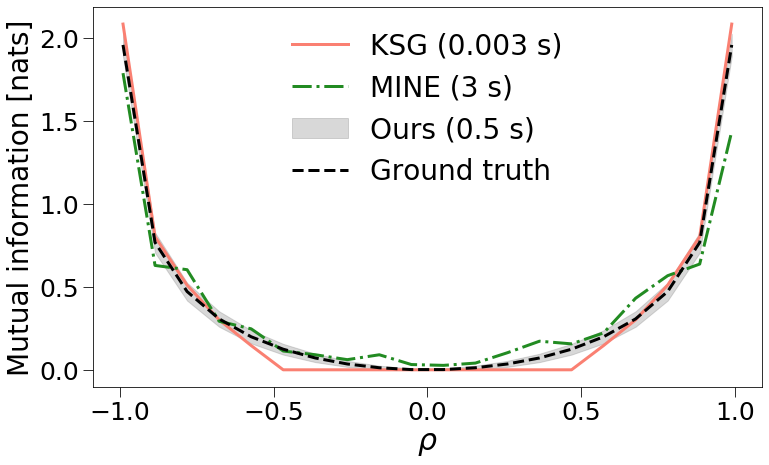

In [33]:
# let's plot all of this
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

lw=3
label = '$N=200$ samples to fit, 20 bootstrap realisations'
ax.tick_params(axis='both', which='major', labelsize=25, size=10)
ax.plot(rhos, knn_estimates, c='salmon', lw=lw, label='KSG (0.003 s)')
ax.plot(rhos, mine_estimates, c='forestgreen', ls='-.', lw=lw, label='MINE (3 s)')
ax.fill_between(rhos, all_MI_estimates[:, 0] - all_MI_estimates[:, 1], all_MI_estimates[:, 0]+all_MI_estimates[:, 1], color='grey', alpha=0.3, label='Ours (0.5 s)')
ax.plot(rhos, analytic, ls='--', c='black', lw=lw, label='Ground truth')

handles, labels = ax.get_legend_handles_labels()
i1, i2 = -1, -2
handles[i1], handles[i2] = handles[i2], handles[i1] 
labels[i1], labels[i2] = labels[i2], labels[i1] 

#ax.set_title(label, fontsize=30)
ax.legend(handles, labels, fontsize=28, frameon=False)
        
#ax.set_ylim((0.38, 0.62))
ax.set_xlabel(r'$\rho$', fontsize=30)
ax.set_ylabel('Mutual information [nats]', fontsize=28);

#plt.savefig('../../figures/D1_comparison.pdf',  bbox_inches='tight');

In [20]:
knn_estimates

[array([1.90977013]),
 array([0.75170782]),
 array([0.49253879]),
 array([0.32331042]),
 array([0.18872735]),
 array([0.07625509]),
 array([0.0158714]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0.0158714]),
 array([0.07625509]),
 array([0.18872735]),
 array([0.32331042]),
 array([0.49253879]),
 array([0.75170782]),
 array([1.90977013])]

In [26]:
handles